In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. The Earned Income Tax Credit increase in 1993 Impact

## 1.a.

**Answer**

From the balance tests, it confirms that pre-treatment differences exist. "children", "nonwhite", "finc", "earn", "age", "ed", "work" are all statistically significant with the treatment. 

This violates the parallel trends assumption needed for DiD, and since treatment is endogenous to those factors. Not controlling for them will be a thread to a precise causal estimate. 

In [3]:
# Import the data 
df = pd.read_csv('../data/eitc.csv')

# Define POST as 1994 and after
df['post'] = (df['year'] >= 1994).astype(int)

# Define TREATED group as respondent who has 1 or more children
df['treated'] = (df['children'] >= 1).astype(int)

df.head()

,state,year,urate,children,nonwhite,finc,earn,age,ed,work,unearn,post,treated
0,11,1991,7.6,0,1,18714.394273,18714.394273,26,10,1,0.000000,0,0
1,12,1991,7.2,1,0,4838.568282,471.365639,22,9,1,4.367203,0,1
2,13,1991,6.4,2,0,8178.193833,0.000000,33,11,0,8.178194,0,1
3,14,1991,9.1,0,1,9369.570485,0.000000,43,11,0,9.369570,0,0
4,15,1991,8.6,3,1,14706.607930,14706.607930,23,7,1,0.000000,0,1


In [4]:
# Produce a summary statistics table showing
# the average values for variables children nonwhite finc earn age ed
# work for single mothers vs. non-mothers in 1992

# Subset 1992 only
df_1992 = df[df['year'] == 1992].copy()

# Summary statistics
cols = ["children", "nonwhite", "finc", "earn", "age", "ed", "work"]
summary_stats = df_1992.groupby('treated')[cols].mean().T
summary_stats.rename(columns = {0:'Non-mothers', 
                                1:'Single-mothers'}, inplace= True)
print("Summary statistics (1992):")
print(summary_stats)

Summary statistics (1992):
treated    Non-mothers  Single-mothers
children      0.000000        2.110795
nonwhite      0.502402        0.629261
finc      18679.671690    12155.405212
earn      13648.970999     7195.169670
age          37.932757       32.820312
ed            8.485110        8.976562
work          0.571566        0.438920


In [11]:
# Run a balance test for each variable in this
# 1992 subsample, e.g., by regressing each variable on the indicator for treated. 
# Discuss what your results imply from an identification perspective

# Balance tests
balance_results = {}
for var in cols:
    model = smf.ols(f"{var} ~ treated", data=df_1992).fit()
    balance_results[var] = model.summary().tables[1]  # Coefficients table

# Print balance results
for var, result in balance_results.items():
    print(f"\nBalance test for {var}:")
    print(result)


Balance test for children:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.634e-14      0.028  -5.76e-13      1.000      -0.056       0.056
treated        2.1108      0.037     56.381      0.000       2.037       2.184

Balance test for nonwhite:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5024      0.015     33.048      0.000       0.473       0.532
treated        0.1269      0.020      6.327      0.000       0.088       0.166

Balance test for finc:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.868e+04    544.256     34.321      0.000    1.76e+04    1.97e+04
treated    -6524.2665    717.789     -9.089      0.

## 1.b. 

**Answer**

Earlier, we detected pre-treatment differences between the two groups. Specifically, single-mothers are 0.1326 less likely to work compared to non-mothers. However, from the graph, we can identify a fairly parallel trends of employment between the two groups. 

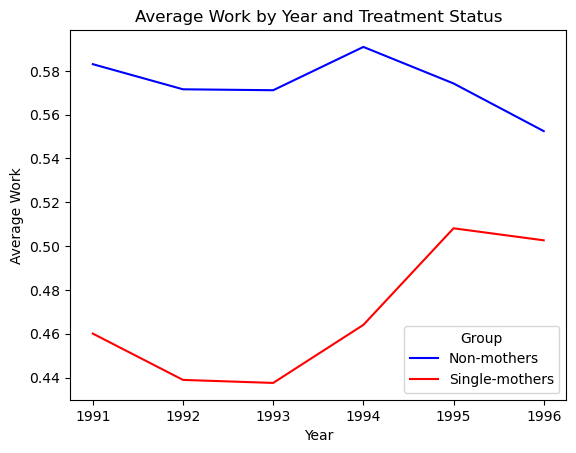

In [6]:
# Calculate the average percent of observations working (i.e., work ==1) 
# by year and treatment status (mothers vs. non).

avg_work = df.groupby(['year', 'treated'])['work'].mean().reset_index()
avg_work['treated'] = avg_work['treated'].map({0: 'Non-mothers', 
                                               1: 'Single-mothers'}) 


# Plot average work separately against year for treated (red), and
# untreated (blue). Do you think the parallel trends assum
sns.lineplot(data=avg_work, x='year', y='work', hue='treated', palette=['blue', 'red'])
plt.title('Average Work by Year and Treatment Status')
plt.xlabel('Year')
plt.ylabel('Average Work')
plt.legend(title='Group')
plt.show()


In [7]:
print(avg_work)

    year         treated      work
0   1991     Non-mothers  0.583032
1   1991  Single-mothers  0.460053
2   1992     Non-mothers  0.571566
3   1992  Single-mothers  0.438920
4   1993     Non-mothers  0.571144
5   1993  Single-mothers  0.437547
6   1994     Non-mothers  0.590909
7   1994  Single-mothers  0.464032
8   1995     Non-mothers  0.574236
9   1995  Single-mothers  0.508127
10  1996     Non-mothers  0.552480
11  1996  Single-mothers  0.502636


## 1.c. 

Use a linear probability model to calculate the DID estimate of the effect of the EITC expansion on whether a respondent was working (i.e., work ==1) for the whole sample by estimating the model \
\
𝑤𝑜𝑟𝑘! = 𝛼 + 𝛽*𝑝𝑜𝑠𝑡 + 𝛽*𝑡𝑟𝑒𝑎𝑡𝑒d + 𝛽*𝑝𝑜𝑠𝑡*𝑡𝑟𝑒𝑎𝑡𝑒d + 𝜀 \
\
first as is, 
and then with fixed effects in state and year. Interpret your results for both regressions, and comment on any differences.

**Answer**

After adding the state and year fixed-effects, the coefficients of treated and post*treated change slightly. This means that the state-level patterns and seasonal shocks on employment did bias the estimates before. 

In [8]:
# DiD estimate of the effect of the EITC expansion on whether a respondent was working
# (i.e., work ==1) for the whole sample
model = smf.ols("work ~ post + treated + post:treated", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   work   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     58.45
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           1.54e-37
Time:                        22:21:34   Log-Likelihood:                -9884.9
No. Observations:               13746   AIC:                         1.978e+04
Df Residuals:                   13742   BIC:                         1.981e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5755      0.009     65.060   

In [9]:
# DiD estimate with fixed effects in state and year
model_fe = smf.ols("work ~ post + treated + post:treated + C(state) + C(year)", data=df).fit()
print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                   work   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     10.68
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           5.52e-91
Time:                        22:21:34   Log-Likelihood:                -9673.0
No. Observations:               13746   AIC:                         1.946e+04
Df Residuals:                   13688   BIC:                         1.990e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4690      0.058     

## 1.d. 

Why might you be concerned about inference, i.e., the calculation of your standard errors, from
these results? What could you do to alleviate these concerns? Implement at least one of the
techniques from Bertrand Duflo and Mullainathan (2004) and report on the change?

**Answer**

Since we know, a state-level or year-level patterns and shocks can affect all the observations in that group. The earlier naive regression treated the each observation as independence. This made the standard errors smaller and underestimated the p-value (false significance). 

So one way to alleviate this concern is to apply clusered standard errors to account for these effects in state and year-level. 

After including the clusted SE, the estimate does not change, but the clustered SE gets larger (0.012 to 0.017) after considering the correlation.

In [10]:
# DID regression with clustered standard errors at the state level
model = smf.ols("work ~ post + treated + post*treated", data=df).fit(
    cov_type="cluster", cov_kwds={"groups": df["state"]}
)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   work   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     37.38
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           8.09e-13
Time:                        22:21:34   Log-Likelihood:                -9884.9
No. Observations:               13746   AIC:                         1.978e+04
Df Residuals:                   13742   BIC:                         1.981e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5755      0.017     34.191   